In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.REPClassifier import REPClassifier
from src.utils.StandardDataset import StandardDataset
from src.utils.perturbations import *

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

ModuleNotFoundError: No module named 'src.utils'

In [8]:
mnist_trainset = datasets.MNIST(root=ROOT+"src/data", train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root=ROOT+"src/data", train=False, download=True, transform=ToTensor())

train_data = mnist_trainset.data.numpy()
train_labels = mnist_trainset.targets.numpy()
test_data = mnist_testset.data.numpy()
test_labels = mnist_testset.targets.numpy()
print(len(train_data), len(test_data))

train_val_split = 0.85
test_split = 0

rep_trainset = StandardDataset(train_data, train_labels, train_val_split)

rep_testset = StandardDataset(test_data, test_labels, test_split)

60000 10000


In [4]:
# Define the perturbation functions
perturbations = [
    gaussian_noise_perturbation(std=2.5),
    gaussian_noise_perturbation(std=5),
    laplacian_noise_perturbation(scale=2),
    laplacian_noise_perturbation(scale=4),
    lp_norm_perturbation(epsilon=50, p=2),
    lp_norm_perturbation(epsilon=100, p=2),
    # lpips_perturbation(std=5),
]

shuffle = True
include_original = True

pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))

# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 32] # must start with a 1 and be at least length--2
linear_sizes = [64, 32]
kernel = 3
model = REPClassifier(channel_widths, linear_sizes, kernel, pool_fcn, 
                      perturbations, include_original, shuffle, 
                      nonlinearity=nn.ReLU(), num_classes=10)

In [9]:
config = {'lr': 1e-3,
          'n_epochs': 5,
          'batch_size': 64}
verbose = True # print metrics during training, False for no printing
model.train_model(rep_trainset, config)

Training interrupted. Stopping after completing 0 epochs of 5 planned.


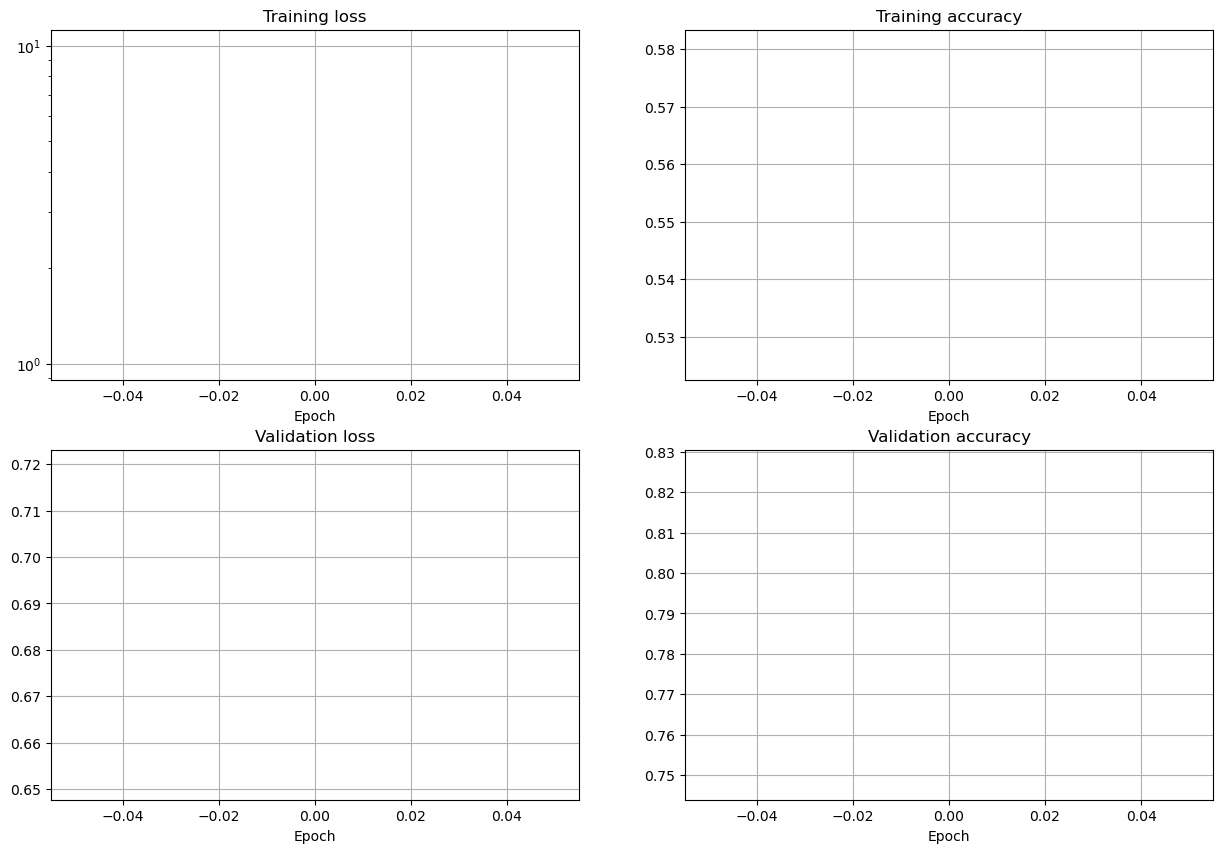

In [7]:
# plot training/validation loss and accuracy over training time
model.plot_model_results()

In [21]:
model_name = 'no_perturbations_01'
model.save_model(ROOT + 'src/models/' + model_name + '.pt')

In [12]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks.evasion import DeepFool
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Step 0: Define the neural network model, return logits instead of activation in forward method


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = DeepFool(classifier=classifier, max_iter=10, )
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.86%


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]